<!-- <img src="./pictures/Netflix.png" style="height: 100%; width:100%"/> -->
<img src="https://static2.cbrimages.com/wordpress/wp-content/uploads/2020/08/Netflix.jpg" style="height: 100%; width:100%"/>


# Netflix Recommendation System

### (Unsupervised Learning Project)

by: Tyler Cranmer

Netflix is one of the most popular media and video streaming platforms. They have over 8000 movies or tv shows available on their platform, as of mid-2021, they have over 200M Subscribers globally. This tabular dataset consists of listings of all the movies and tv shows available on Netflix, along with details such as - cast, directors, ratings, release year, duration, etc.
 
This goal of this project is to create a movie / tv-show recommendation system. When given a movie title, will generate the top 5 movie or shows to watch. The purpose of this project was to build my skills with recommendation systems and using NLP models.

## Data Explanation

https://www.kaggle.com/datasets/shivamb/netflix-shows

NetFlix Data has 8807 movies with 12 features.<br />

**Features:** 
<br />
**show_id:** Unique ID for every movie / tv show <br />
**type:** Identifier - A movie or tv show <br />
**title:** Title of the movie / tv show <br />
**director:** Director of the movie <br />
**cast:** Actors involved in the movie / show <br />
**country:** Country where the movie / show was produced <br />
**date_added:** Date it was added on Netflix <br />
**release_year:** Actual Release year of the move / show <br />
**rating:** TV Rating of the movie / show <br />
**listed_in:** Genere <br />
**description:** The summary of description <br />

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import re
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

#preprocessing
import nltk
from nltk.corpus import stopwords

## EDA

In [2]:
data = pd.read_csv('./data/netflix_titles.csv')
print(f'Netflix movie data frame shape: {data.shape} \n')
data.head()

Netflix movie data frame shape: (8807, 12) 



,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [3]:
data.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB



We can see from the Netflix Data Completeness graph, there are a couple important features missing data. ~30% of the movies are missing a named director, ~10% are missing the list of cast members, ~10% are missing the country, and <1% of the data is missing from the other categories. 



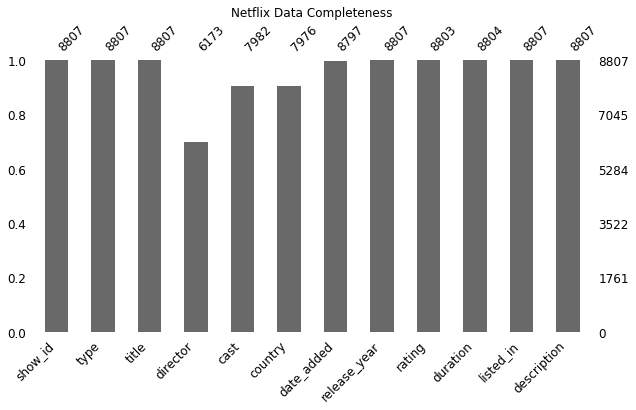

In [4]:
msno.bar(data, figsize=(10,5), fontsize=12);
plt.title("Netflix Data Completeness");
print("\nWe can see from the Netflix Data Completeness graph, there are a couple important features missing data. ~30% of the movies are missing a named director, ~10% are missing the list of cast members, ~10% are missing the country, and <1% of the data is missing from the other categories. \n")

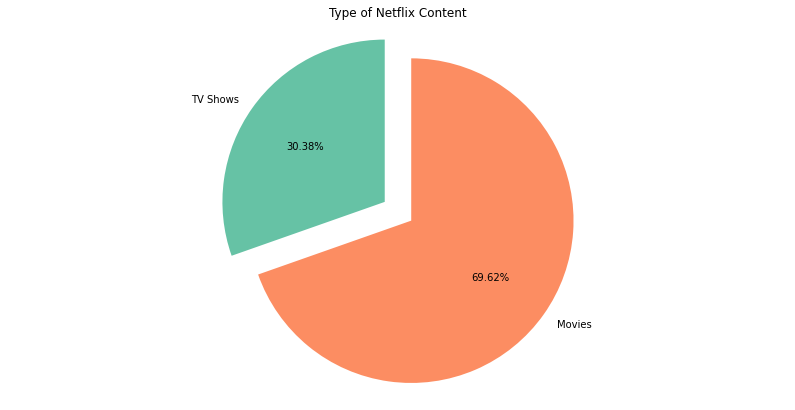


 The dataset consists of 6131 Movies and 2676 TV Shows


In [5]:
labels = ['TV Shows', 'Movies']
colors = sns.color_palette('Set2')
plt.figure(figsize=(14, 7))
plt.pie(data['type'].value_counts().sort_values(), labels = labels, colors = colors, autopct='%1.2f%%', explode=[0.1,0.1], startangle=90)
plt.title("Type of Netflix Content")
plt.axis('equal')
plt.show()
print("\n The dataset consists of 6131 Movies and 2676 TV Shows")

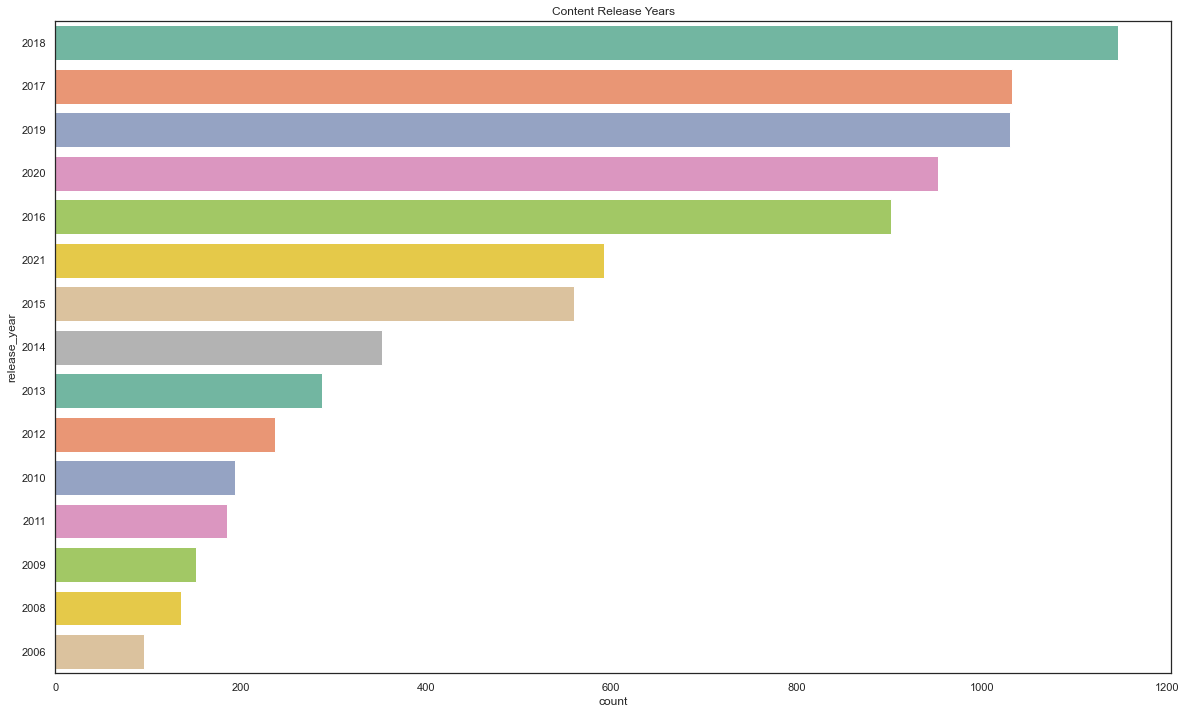

In [6]:
plt.figure(figsize=(20,12))
sns.set(style="white")
sns.countplot(y="release_year", data=data, palette="Set2", order=data['release_year'].value_counts().index[0:15])
plt.title("Content Release Years");

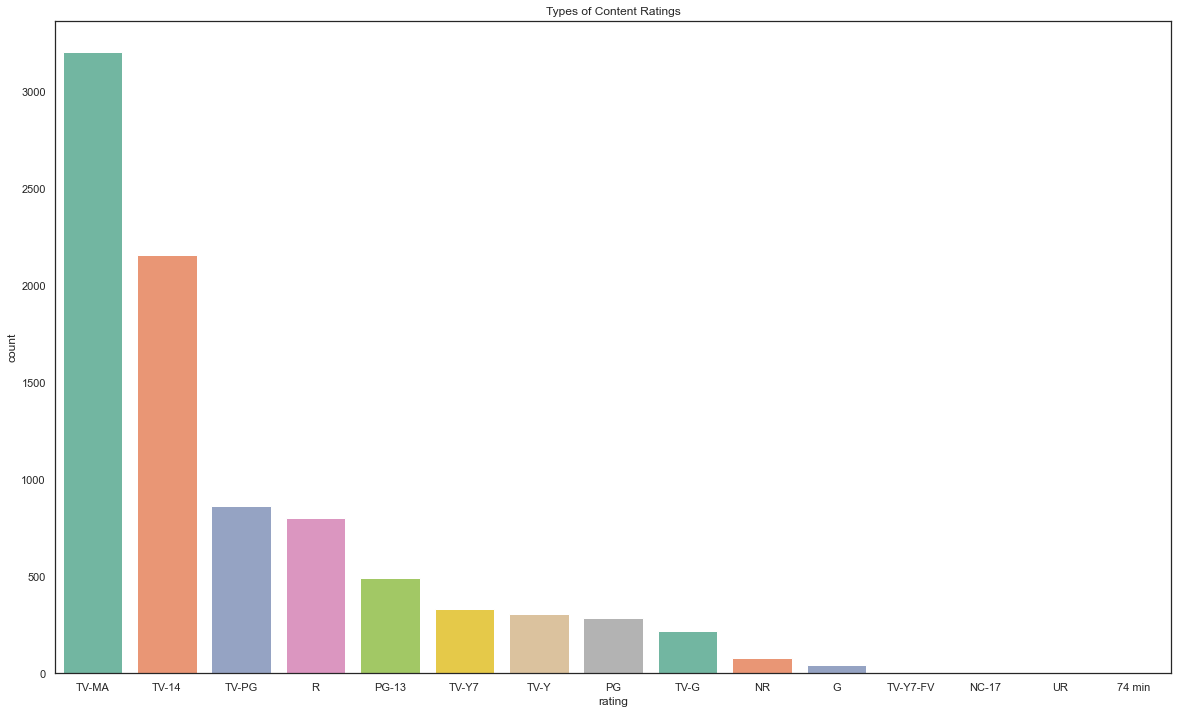

In [7]:
plt.figure(figsize=(20,12))
sns.set_style("white")
sns.countplot(x="rating", data=data, palette="Set2", order=data['rating'].value_counts().index[0:15]);
plt.title("Types of Content Ratings");
plt.show();

I think we have a fairly healthy set of data to use for creating movie recommendations. My biggest concern right now, is the number of null values in the directors and cast features. With that said, how the movie feature vectors will be set up, we will still have enough data to create solid recommendations. Also, the calc_movie_feature_matrix() handle null values with in the data set.

<br>

Cleaning of the description data will be done at the bottom of the project, once we get into using the TfidfVectorizer model. 

## Recommendation Systems

There are several types of recommendation system techniques. Collaborative Filtering, Content Based Filtering and Hybrid Recommendation Systems being some of them. Each type of systems can be used to help predict or recommend a wide variety of products to consumers like similar movies or music. This project is going to focus on Content Based Filtering.

<img src="./pictures/recommendation_system.png" style="height: 361px; width:420px; display: block; margin-left: auto; margin-right: auto"/>

## Content Based Filtering

Content-based filtering methods are based on the description of a product and a profile of the user preferred choices. Since this data set does not have any information about users, we will be finding recommendations for other movies based off a similarity metric of one movie to another.

<img src="./pictures/CBF.png" style="height: 482px; width:371px; display: block; margin-left: auto; margin-right: auto"/>

## Developing Recommendation System using director, cast, country, rating and listed_in (genre)

We will create our own feature count vectorizer by creating a giant movie feature matrix that consists of all directors, cast, countries, rating, and genres. After creating the matrix we will utilize two different item-item similarity metrics to create a similarity value between every movie.

In [8]:
drop_columns = ['show_id', 'date_added', 'release_year', 'duration']
for col in drop_columns:
    data.drop(col, axis=1, inplace=True)

## Creating a Movie Feature Matrix

In [40]:
def calc_movie_feature_matrix(feature_column: pd.Series) ->  np.ndarray:
    """
    General Purpose Movie Feature Matrix function
    example: pass in data['director'], to get a matrix (#allmovies, #alldirectors)
    """

    isNan = False
    feature_list = []
    for i, items in enumerate(feature_column):
        if pd.isna(items):
            feature_list.append(['']) #place holder for nan values
            isNan = True
        else:
            item_list = re.split(r', \s*', items)
            feature_list.append(item_list)
        
    flatten_features = [item for sublist in feature_list for item in sublist]
    unique_features = list(np.unique(flatten_features))

    if isNan == True: # check if Nan value was passed through.
        unique_features = unique_features[1:] # '' is at index 0. this removes that value from list.
    
    index = {} #key: feature's name  value: column index
    for i, name in enumerate(unique_features):
        index[name] = i

    matrix = np.zeros((feature_column.shape[0], len(unique_features))) # (#movies, #unique features)
    for i, items in enumerate(feature_list): # update feature matrix with 1.0 where a movie has a particular feature. i.e specific director or actor. 
        movie = np.zeros(len(unique_features)) # movie array w/ all 0's
        if len(items) > 1:
            for item in items:
                if item != '': # this line of code ignores features that are not null but have empty strings w/in the category. ex: ['', 'France']
                    movie[index[item]] = 1.0
            matrix[i] = movie
        elif items == ['']:
            matrix[i] = movie
        else:
            movie[index[items[0]]] = 1.0
            matrix[i] = movie
    return matrix

### Calculating Movie Feature Matrix
We will find the movie feature matrixes for each category and then combine them to make one giant matrix. As you can see bellow, the final movie feature matrix will consist of 0s and 1s, where the presence of a feature in a movie will be 1 and the absence of said feature is 0. 

In [10]:
movie_director = calc_movie_feature_matrix(data['director'])
movie_cast = calc_movie_feature_matrix(data['cast'])
movie_country = calc_movie_feature_matrix(data['country'])
movie_rating = calc_movie_feature_matrix(data['rating'])
movie_genre = calc_movie_feature_matrix(data['listed_in'])
feature_matrix = np.concatenate((movie_director, movie_cast, movie_country, movie_rating, movie_genre), axis = 1)
print(f'Movie Feature Matrix shape: {feature_matrix.shape}')
print(feature_matrix)

Movie Feature Matrix shape: (8807, 41617)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Jaccard Similarity / Jaccard Index

The Jaccard Similarity Index is a measure of the similarity between two sets of data. It is a common proximity measurement used to compute the similarity between two objects, such as two movies. You can find the similarity ratio by taking the intersection over union of two sets.

$$J(A,B) = {{|A \cap B|}\over{|A \cup B|}} = {{|A \cap B|}\over{|A| + |B| - |A \cap B|}}$$

In [11]:
def jaccsim(feature_matrix:  np.ndarray) -> np.ndarray:
    """
    Create item-item similarity using Jaccard similarity
    J(A,B) = |A interect B| / | A union B|
    """
    jacc_sim = np.zeros((feature_matrix.shape[0],feature_matrix.shape[0]))
    a = feature_matrix
    b = feature_matrix.T

    intersection = a @ b # |A interect B|

    a_union = a.sum(axis=1)
    a_union= a_union.reshape((len(a_union),1))
    b_union = b.sum(axis=0)

    union = (a_union + b_union) - intersection # | A union B|

    jacc_sim = np.divide(intersection, union, out=np.zeros_like(intersection), where=union!=0)

    return jacc_sim

## Cosine Similary

The Cosine Similarity metric is another commonly used measurement for recommendation systems. It measures the similarity between two sequences of numbers by viewing each vector in an inner product space, and the cosine similarity is defined as the cosine of the angle between them. The dot product of the vectors divided by the product of their lengths.

$$\text{cosine similarity} =S_C (A,B):= \cos(\theta) = {\mathbf{A} \cdot \mathbf{B} \over \|\mathbf{A}\| \|\mathbf{B}\|} = \frac{ \sum\limits_{i=1}^{n}{A_i  B_i} }{ \sqrt{\sum\limits_{i=1}^{n}{A_i^2}}  \sqrt{\sum\limits_{i=1}^{n}{B_i^2}} }$$


In [12]:
def cossim(feature_matrix:  np.ndarray) -> np.ndarray:
    """
    Create item-item similarity using Cosine Similarity
    cossim = A dot B / ||A||*||B||
    """
    cos_sim = np.zeros((feature_matrix.shape[0],feature_matrix.shape[0]))
    a = feature_matrix
    b = feature_matrix.T
    
    numerator = a @ b
    
    a_mag = np.sqrt(np.square(a).sum(axis=1))     # ||A||
    a_mag = a_mag.reshape((len(a_mag),1))         # ||A|| reshaped to to help with matrix multiplication
    b_mag = np.sqrt(np.square(b).sum(axis=0))     # ||B||


    denominator = a_mag * b_mag             # ||A|| * ||B||

    cos_sim = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0) #      (A dot B) / ||A||*||B||  
    return cos_sim

### Generating Movie Similarity Matrix 

Both functions create a matrix that consists of the similarity values of each movie compared to another. So, the shape of this matrix will be (all movies, all movies), where the max value between a movie is 1, meaning both movies are identical or 0 meaning they are completely different.

In [13]:
jaccard_similarity = jaccsim(feature_matrix)
cosine_similarity = cossim(feature_matrix)

In [14]:
print(f'Jaccard Similarity Matrix: \nShape: {jaccard_similarity.shape} \n {jaccard_similarity}')
print(f'\n\nCosine Similarity Matrix: \nShape: {cosine_similarity.shape} \n {cosine_similarity}')

Jaccard Similarity Matrix: 
Shape: (8807, 8807) 
 [[1.         0.         0.         ... 0.06666667 0.05882353 0.        ]
 [0.         1.         0.05555556 ... 0.         0.         0.        ]
 [0.         0.05555556 1.         ... 0.         0.         0.        ]
 ...
 [0.06666667 0.         0.         ... 1.         0.08333333 0.        ]
 [0.05882353 0.         0.         ... 0.08333333 1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


Cosine Similarity Matrix: 
Shape: (8807, 8807) 
 [[1.         0.         0.         ... 0.14433757 0.13363062 0.        ]
 [0.         1.         0.10910895 ... 0.         0.         0.        ]
 [0.         0.10910895 1.         ... 0.         0.         0.        ]
 ...
 [0.14433757 0.         0.         ... 1.         0.15430335 0.        ]
 [0.13363062 0.         0.         ... 0.15430335 1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


## Creating Recommendation Function 


In [15]:
def get_recommendation(title: str, similarity_matrix: np.ndarray) -> pd.DataFrame:
    """
    generates top 5 recommended movies to watch, based off of inputed title.
    title: string
    similarity_matrix: similarity function. ex: jacsim or cossim
    """
    if title in list(data['title']):
        movie_indices = pd.Series(data.index, index= data['title'])
        idx = movie_indices[title]
        sim_scores = enumerate(similarity_matrix[idx])
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        top_5_sim_scores = sim_scores[1:6]
        top_5_index = [x[0] for x in top_5_sim_scores]
        result = data.iloc[top_5_index]
        print(f'(content index, score) : {sim_scores[1:6]}')
        return result
    else:
        print('Title Not Found')

### Generating Recommendations

We will be generating the top 5 recommended movies to watch based off of an inputed movie title. We will also compare results between the jaccard and cosine similarity functions.

### Austin Powers

In [16]:
get_recommendation('Austin Powers: International Man of Mystery', jaccard_similarity)

(content index, score) : [(563, 0.55), (561, 0.45), (6655, 0.16666666666666666), (2330, 0.15384615384615385), (6049, 0.15384615384615385)]


,type,title,director,cast,country,rating,listed_in,description
563,Movie,Austin Powers: The Spy Who Shagged Me,Jay Roach,"Mike Myers, Heather Graham, Michael York, Robe...",United States,PG-13,"Action & Adventure, Comedies, Sci-Fi & Fantasy",When diabolical genius Dr. Evil travels back i...
561,Movie,Austin Powers in Goldmember,Jay Roach,"Mike Myers, Beyoncé Knowles-Carter, Seth Green...",United States,PG-13,"Action & Adventure, Comedies",The world's most shagadelic spy continues his ...
6655,Movie,Dumb and Dumberer: When Harry Met Lloyd,Troy Miller,"Eric Christian Olsen, Derek Richardson, Rachel...",United States,PG-13,Comedies,This wacky prequel to the 1994 blockbuster goe...
2330,Movie,Eurovision Song Contest: The Story of Fire Saga,David Dobkin,"Will Ferrell, Rachel McAdams, Dan Stevens, Mel...",United States,PG-13,"Comedies, Music & Musicals, Romantic Movies",Two small-town singers chase their pop star dr...
6049,Movie,A Night at the Roxbury,John Fortenberry,"Will Ferrell, Chris Kattan, Dan Hedaya, Molly ...",United States,PG-13,"Comedies, Cult Movies","After a run-in with Richard Grieco, dimwits Do..."


In [17]:
get_recommendation('Austin Powers: International Man of Mystery', cosine_similarity)

(content index, score) : [(563, 0.710046946804693), (561, 0.6210590034081188), (6655, 0.2864459496157732), (2330, 0.2666666666666666), (6049, 0.2666666666666666)]


,type,title,director,cast,country,rating,listed_in,description
563,Movie,Austin Powers: The Spy Who Shagged Me,Jay Roach,"Mike Myers, Heather Graham, Michael York, Robe...",United States,PG-13,"Action & Adventure, Comedies, Sci-Fi & Fantasy",When diabolical genius Dr. Evil travels back i...
561,Movie,Austin Powers in Goldmember,Jay Roach,"Mike Myers, Beyoncé Knowles-Carter, Seth Green...",United States,PG-13,"Action & Adventure, Comedies",The world's most shagadelic spy continues his ...
6655,Movie,Dumb and Dumberer: When Harry Met Lloyd,Troy Miller,"Eric Christian Olsen, Derek Richardson, Rachel...",United States,PG-13,Comedies,This wacky prequel to the 1994 blockbuster goe...
2330,Movie,Eurovision Song Contest: The Story of Fire Saga,David Dobkin,"Will Ferrell, Rachel McAdams, Dan Stevens, Mel...",United States,PG-13,"Comedies, Music & Musicals, Romantic Movies",Two small-town singers chase their pop star dr...
6049,Movie,A Night at the Roxbury,John Fortenberry,"Will Ferrell, Chris Kattan, Dan Hedaya, Molly ...",United States,PG-13,"Comedies, Cult Movies","After a run-in with Richard Grieco, dimwits Do..."


### American Psycho

In [18]:
get_recommendation('American Psycho', jaccard_similarity)


(content index, score) : [(6450, 0.19230769230769232), (6034, 0.18518518518518517), (4921, 0.16666666666666666), (6928, 0.16666666666666666), (8443, 0.16666666666666666)]


,type,title,director,cast,country,rating,listed_in,description
6450,Movie,Chasing Amy,Kevin Smith,"Ben Affleck, Joey Lauren Adams, Jason Lee, Dwi...",United States,R,"Comedies, Cult Movies, Dramas",Comic book artist Holden meets the perfect wom...
6034,Movie,A Family Man,Mark Williams,"Gerard Butler, Gretchen Mol, Alison Brie, Will...","Canada, United States",R,Dramas,A ruthless corporate headhunter battles his ri...
4921,Movie,Kodachrome,Mark Raso,"Ed Harris, Jason Sudeikis, Elizabeth Olsen","Canada, United States",TV-MA,"Comedies, Dramas","A record company exec joins his estranged dad,..."
6928,Movie,Harold & Kumar Go to White Castle,Danny Leiner,"John Cho, Kal Penn, Paula Garcés, Neil Patrick...","United States, Canada, Germany",R,"Comedies, Cult Movies",Buddies Harold and Kumar set out to satisfy a ...
8443,Movie,The One I Love,Charlie McDowell,"Mark Duplass, Elisabeth Moss, Ted Danson",United States,R,"Comedies, Dramas, Independent Movies",Confronted with the potential end of their mar...


In [19]:
get_recommendation('American Psycho', cosine_similarity)

(content index, score) : [(3629, 0.3441236008058426), (6450, 0.33113308926626095), (6034, 0.31814238148788887), (4921, 0.30588764516074896), (8443, 0.30588764516074896)]


,type,title,director,cast,country,rating,listed_in,description
3629,Movie,Otherhood,NaN,NaN,"United Kingdom, United States",R,Comedies,"Feeling forgotten on Mother's Day, three best ..."
6450,Movie,Chasing Amy,Kevin Smith,"Ben Affleck, Joey Lauren Adams, Jason Lee, Dwi...",United States,R,"Comedies, Cult Movies, Dramas",Comic book artist Holden meets the perfect wom...
6034,Movie,A Family Man,Mark Williams,"Gerard Butler, Gretchen Mol, Alison Brie, Will...","Canada, United States",R,Dramas,A ruthless corporate headhunter battles his ri...
4921,Movie,Kodachrome,Mark Raso,"Ed Harris, Jason Sudeikis, Elizabeth Olsen","Canada, United States",TV-MA,"Comedies, Dramas","A record company exec joins his estranged dad,..."
8443,Movie,The One I Love,Charlie McDowell,"Mark Duplass, Elisabeth Moss, Ted Danson",United States,R,"Comedies, Dramas, Independent Movies",Confronted with the potential end of their mar...


### Stranger Things

In [20]:
get_recommendation('Stranger Things',jaccard_similarity)

(content index, score) : [(5200, 0.5862068965517241), (2190, 0.17391304347826086), (1473, 0.14285714285714285), (241, 0.13793103448275862), (4709, 0.13333333333333333)]


,type,title,director,cast,country,rating,listed_in,description
5200,TV Show,Beyond Stranger Things,NaN,"Jim Rash, Matt Duffer, Ross Duffer, Shawn Levy...",United States,TV-14,"Stand-Up Comedy & Talk Shows, TV Mysteries, TV...","Secrets from the ""Stranger Things 2"" universe ..."
2190,TV Show,The Umbrella Academy,NaN,NaN,"United States, Canada",TV-14,"TV Action & Adventure, TV Mysteries, TV Sci-Fi...","Reunited by their father's death, estranged si..."
1473,TV Show,Chilling Adventures of Sabrina,NaN,"Kiernan Shipka, Ross Lynch, Miranda Otto, Lucy...",United States,TV-14,"TV Horror, TV Mysteries, TV Sci-Fi & Fantasy","Magic and mischief collide as half-human, half..."
241,TV Show,Manifest,NaN,"Melissa Roxburgh, Josh Dallas, Athena Karkanis...",United States,TV-14,"TV Dramas, TV Mysteries, TV Sci-Fi & Fantasy",When a plane mysteriously lands years after ta...
4709,TV Show,The Originals,NaN,"Joseph Morgan, Daniel Gillies, Phoebe Tonkin, ...",United States,TV-14,"TV Dramas, TV Horror, TV Mysteries",The Mikaelsons move to New Orleans and form an...


In [21]:
get_recommendation('Stranger Things', cosine_similarity)

(content index, score) : [(5200, 0.7419408268023742), (2190, 0.35634832254989923), (8541, 0.29277002188455997), (657, 0.2672612419124244), (1127, 0.2672612419124244)]


,type,title,director,cast,country,rating,listed_in,description
5200,TV Show,Beyond Stranger Things,NaN,"Jim Rash, Matt Duffer, Ross Duffer, Shawn Levy...",United States,TV-14,"Stand-Up Comedy & Talk Shows, TV Mysteries, TV...","Secrets from the ""Stranger Things 2"" universe ..."
2190,TV Show,The Umbrella Academy,NaN,NaN,"United States, Canada",TV-14,"TV Action & Adventure, TV Mysteries, TV Sci-Fi...","Reunited by their father's death, estranged si..."
8541,TV Show,The Twilight Zone (Original Series),NaN,Rod Serling,United States,TV-14,"Classic & Cult TV, TV Sci-Fi & Fantasy","Hosted by creator Rod Serling, this groundbrea..."
657,TV Show,The Mole,NaN,Anderson Cooper,United States,TV-14,"Reality TV, TV Action & Adventure, TV Mysteries","In this competition show, contestants try to e..."
1127,TV Show,Prank Encounters,NaN,Gaten Matarazzo,United States,TV-MA,"Reality TV, TV Comedies, TV Horror",Monstrous frights meet hilarious reveals on th...


### Avatar: The Last Airbender

In [22]:
get_recommendation('Avatar: The Last Airbender', jaccard_similarity)

(content index, score) : [(2135, 0.23809523809523808), (3246, 0.22727272727272727), (5035, 0.2222222222222222), (7721, 0.2), (855, 0.19047619047619047)]


,type,title,director,cast,country,rating,listed_in,description
2135,TV Show,The Legend of Korra,NaN,"Janet Varney, David Faustino, P.J. Byrne, J.K....",United States,TV-Y7,"Kids' TV, TV Action & Adventure, TV Sci-Fi & F...",A female avatar who can control the elements f...
3246,TV Show,The Dragon Prince,NaN,"Jack De Sena, Paula Burrows, Sasha Rojen, Jaso...","United States, Canada",TV-Y7,"Kids' TV, TV Action & Adventure, TV Sci-Fi & F...",An extraordinary discovery inspires two human ...
5035,TV Show,Dragons: Race to the Edge,NaN,"Jay Baruchel, America Ferrera, T.J. Miller, Ch...",United States,TV-Y7,"Kids' TV, TV Action & Adventure","From the creators of ""How to Train Your Dragon..."
7721,TV Show,Pee-wee's Playhouse,NaN,Paul Reubens,United States,TV-PG,"Classic & Cult TV, Kids' TV, TV Comedies",Pee-wee Herman brings his stage show to the ma...
855,TV Show,Jurassic World Camp Cretaceous,NaN,"Paul-Mikél Williams, Jenna Ortega, Sean Giambr...",United States,TV-Y7,"Kids' TV, TV Action & Adventure, TV Sci-Fi & F...",Six teens invited to attend a state-of-the-art...


In [23]:
get_recommendation('Avatar: The Last Airbender', cosine_similarity)

(content index, score) : [(123, 0.40824829046386296), (936, 0.40824829046386296), (2135, 0.3857583749052298), (3246, 0.372677996249965), (5035, 0.3651483716701107)]


,type,title,director,cast,country,rating,listed_in,description
123,TV Show,Luv Kushh,NaN,NaN,NaN,TV-Y7,Kids' TV,"Based on the last book of the epic Ramayana, t..."
936,TV Show,Miniforce: Super Dino Power,NaN,NaN,NaN,TV-Y7,Kids' TV,Animals with special powers transform into sup...
2135,TV Show,The Legend of Korra,NaN,"Janet Varney, David Faustino, P.J. Byrne, J.K....",United States,TV-Y7,"Kids' TV, TV Action & Adventure, TV Sci-Fi & F...",A female avatar who can control the elements f...
3246,TV Show,The Dragon Prince,NaN,"Jack De Sena, Paula Burrows, Sasha Rojen, Jaso...","United States, Canada",TV-Y7,"Kids' TV, TV Action & Adventure, TV Sci-Fi & F...",An extraordinary discovery inspires two human ...
5035,TV Show,Dragons: Race to the Edge,NaN,"Jay Baruchel, America Ferrera, T.J. Miller, Ch...",United States,TV-Y7,"Kids' TV, TV Action & Adventure","From the creators of ""How to Train Your Dragon..."


### My Secret Romance

In [24]:
get_recommendation('My Secret Romance', jaccard_similarity)

(content index, score) : [(7480, 0.3125), (5598, 0.29411764705882354), (5509, 0.2777777777777778), (5673, 0.2777777777777778), (3640, 0.2631578947368421)]


,type,title,director,cast,country,rating,listed_in,description
7480,TV Show,Momo Salon,NaN,"Lizzy, Jung-min Park, Sang-hee Lee",South Korea,TV-14,"International TV Shows, Korean TV Shows, Roman...",An aspiring hair stylist opens her own salon. ...
5598,TV Show,Love for Ten: Generation of Youth,NaN,"Sung-yeol Lee, Ji-hyun Nam, Clara Lee, Jin Won",South Korea,TV-14,"International TV Shows, Korean TV Shows, Roman...",A nerdy engineering student falls for a pretty...
5509,TV Show,Jumping Girl,NaN,"Luna, U-kwon, Ha-na Jung, B-Bomb, Ha-seong Park",South Korea,TV-14,"International TV Shows, Korean TV Shows, Roman...",Sang-ah would do anything to shield pop star A...
5673,TV Show,K-POP Extreme Survival,NaN,"Jung Eun Kim, Yu-hwan Park, Eun-ah Go, Yong Hw...",South Korea,TV-14,"International TV Shows, Korean TV Shows, Roman...",Seung Yeon decides to chase her dream of becom...
3640,TV Show,My First First Love,NaN,"Ji Soo, Jung Chae-yeon, Jinyoung, Choi Ri, Kan...",South Korea,TV-14,"International TV Shows, Korean TV Shows, Roman...","Due to various personal reasons, a group of Yu..."


In [25]:
get_recommendation('My Secret Romance', cosine_similarity)

(content index, score) : [(7480, 0.49029033784546), (5598, 0.4622501635210243), (5509, 0.43852900965351466), (5673, 0.43852900965351466), (3640, 0.41812100500354543)]


,type,title,director,cast,country,rating,listed_in,description
7480,TV Show,Momo Salon,NaN,"Lizzy, Jung-min Park, Sang-hee Lee",South Korea,TV-14,"International TV Shows, Korean TV Shows, Roman...",An aspiring hair stylist opens her own salon. ...
5598,TV Show,Love for Ten: Generation of Youth,NaN,"Sung-yeol Lee, Ji-hyun Nam, Clara Lee, Jin Won",South Korea,TV-14,"International TV Shows, Korean TV Shows, Roman...",A nerdy engineering student falls for a pretty...
5509,TV Show,Jumping Girl,NaN,"Luna, U-kwon, Ha-na Jung, B-Bomb, Ha-seong Park",South Korea,TV-14,"International TV Shows, Korean TV Shows, Roman...",Sang-ah would do anything to shield pop star A...
5673,TV Show,K-POP Extreme Survival,NaN,"Jung Eun Kim, Yu-hwan Park, Eun-ah Go, Yong Hw...",South Korea,TV-14,"International TV Shows, Korean TV Shows, Roman...",Seung Yeon decides to chase her dream of becom...
3640,TV Show,My First First Love,NaN,"Ji Soo, Jung Chae-yeon, Jinyoung, Choi Ri, Kan...",South Korea,TV-14,"International TV Shows, Korean TV Shows, Roman...","Due to various personal reasons, a group of Yu..."


# Recommendation System Utilizing Movie Descriptions and TF-IDF

TF-IDF stands for **Term Frequency-Inverse Document Frequency**. It is a measurement that can quantify the importance or relevance of string representations in a document amongst a collection of documents.

TF - Term Frequency, is a way to represent how often a word occurs in a document. If there are several occurrences of a word in the document, we expect the TF to rise. To find the TF, you take the number of occurrences of a word and divide that by the total number of words in the document.

$$
t f_{i, j}=\frac{n_{i, j}}{\sum_{k} n_{i, j}}
$$

        
IDF - Inverse Data Frequency, is another way to represent how common a word is across all documents. If a word is used in many documents, then the TF-IDF value would decrease.

$$
i d f(w)=\log \left(\frac{N}{d f_{t}}\right)
$$

To summarize the key intuition motivating TF-IDF is the importance of a term is inversely related to its frequency across documents. TF gives us information on how often a term appears in a document and IDF gives us information about the relative rarity of a term in the collection of documents. By multiplying these values together we can get our final TF-IDF value.

<br>

We will be using sklearn's built in model TfidfVectorizer to accomplish this task.

<br> https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

### Cleaning Text Data

I have created a clean_text function that will covert all words to lowercase, remove any stop words, remove punctions and extra white space.

In [26]:
def clean_text(df: pd.Series) -> pd.Series:     
    stop_words = stopwords.words('english')
    removed_stop_words = df['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    cleaned_description = []
    for i, v in enumerate(removed_stop_words):
        string = re.sub(r'[^-\w\s]+', '', removed_stop_words[i]) # removes punctuation
        string = re.sub(r'[^\w\s]+', ' ', string) #replaced - with space
        string = re.sub(' +', ' ', string) #removes any extra space
        lower_case_desc = string.lower()
        cleaned_description.append(lower_case_desc) 
    df = df.assign(c_description=cleaned_description)
    return df.c_description

In [27]:
c_description = clean_text(data)
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df = 0.95, norm = 'l2')
tfidf = tfidf_vectorizer.fit_transform(c_description)
cos_sim_tfidf = linear_kernel(tfidf) # linear_kernel built in method for cosine similarity

# Results and Comparison Between Models

### Hubie Halloween

In [28]:
# Recommendation w/ using TF-IDF with content description
get_recommendation('Hubie Halloween', cos_sim_tfidf)

(content index, score) : [(1892, 0.15375776051218354), (3442, 0.13742593114539806), (84, 0.1292161785442927), (7488, 0.12826627335265045), (8803, 0.12078201544771754)]


,type,title,director,cast,country,rating,listed_in,description
1892,Movie,A Go! Go! Cory Carson Halloween,"Alex Woo, Stanley Moore","Alan C. Lim, Smith Foreman, Maisie Benson, Ann...",NaN,TV-Y,Children & Family Movies,"Cory, Chrissy and Freddie are on the hunt for ..."
3442,Movie,The Spooky Tale of Captain Underpants Hack-a-ween,NaN,"Nat Faxon, Jay Gragnani, Ramone Hamilton, Sean...",United States,TV-Y7,"Children & Family Movies, Comedies","When Melvin tries to cancel Halloween, clever ..."
84,Movie,Omo Ghetto: the Saga,"JJC Skillz, Funke Akindele","Funke Akindele, Ayo Makun, Chioma Chukwuka Akp...",Nigeria,TV-MA,"Action & Adventure, Comedies, Dramas",Twins are reunited as a good-hearted female ga...
7488,Movie,Monster Family,Holger Tappe,"Celia Imrie, Emily Watson, Catherine Tate, Jas...","Germany, United Kingdom",PG,Children & Family Movies,A family’s festive Halloween plans take a spoo...
8803,TV Show,Zombie Dumb,NaN,NaN,NaN,TV-Y7,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g..."


In [29]:
# Recommendation w/ cosine similarity
get_recommendation('Hubie Halloween', cosine_similarity)

(content index, score) : [(27, 0.4391550328268399), (5533, 0.30304576336566325), (6018, 0.2927700218845599), (7517, 0.2927700218845599), (4482, 0.25354627641855493)]


,type,title,director,cast,country,rating,listed_in,description
27,Movie,Grown Ups,Dennis Dugan,"Adam Sandler, Kevin James, Chris Rock, David S...",United States,PG-13,Comedies,Mourning the loss of their beloved junior high...
5533,Movie,Sandy Wexler,Steven Brill,"Adam Sandler, Jennifer Hudson, Kevin James, Te...",United States,TV-14,Comedies,When a hapless but dedicated talent manager si...
6018,Movie,50 First Dates,Peter Segal,"Adam Sandler, Drew Barrymore, Rob Schneider, S...",United States,PG-13,"Comedies, Romantic Movies",After falling for a pretty art teacher who has...
7517,Movie,Mr. Deeds,Steve Brill,"Adam Sandler, Winona Ryder, Peter Gallagher, J...",United States,PG-13,"Comedies, Romantic Movies","After inheriting a media empire, humble Longfe..."
4482,Movie,ADAM SANDLER 100% FRESH,Steve Brill,Adam Sandler,United States,TV-MA,Stand-Up Comedy,"From ""Heroes"" to ""Ice Cream Ladies"" – Adam San..."


In [30]:
# Recommendation w/ jaccard similarity
get_recommendation('Hubie Halloween', jaccard_similarity)

(content index, score) : [(27, 0.2647058823529412), (5533, 0.16666666666666666), (6018, 0.16216216216216217), (7517, 0.16216216216216217), (6303, 0.13513513513513514)]


,type,title,director,cast,country,rating,listed_in,description
27,Movie,Grown Ups,Dennis Dugan,"Adam Sandler, Kevin James, Chris Rock, David S...",United States,PG-13,Comedies,Mourning the loss of their beloved junior high...
5533,Movie,Sandy Wexler,Steven Brill,"Adam Sandler, Jennifer Hudson, Kevin James, Te...",United States,TV-14,Comedies,When a hapless but dedicated talent manager si...
6018,Movie,50 First Dates,Peter Segal,"Adam Sandler, Drew Barrymore, Rob Schneider, S...",United States,PG-13,"Comedies, Romantic Movies",After falling for a pretty art teacher who has...
7517,Movie,Mr. Deeds,Steve Brill,"Adam Sandler, Winona Ryder, Peter Gallagher, J...",United States,PG-13,"Comedies, Romantic Movies","After inheriting a media empire, humble Longfe..."
6303,Movie,Big Daddy,Dennis Dugan,"Adam Sandler, Joey Lauren Adams, Jon Stewart, ...",United States,PG-13,Comedies,Dumped by his girlfriend because he refuses to...


### The Good Place

In [31]:
# Recommendation w/ using TF-IDF with content description
get_recommendation('The Good Place', cos_sim_tfidf)

(content index, score) : [(1252, 0.17706481002960006), (7376, 0.17182031092360234), (1109, 0.1598282914835707), (5247, 0.13155592027710572), (7015, 0.12460563513691912)]


,type,title,director,cast,country,rating,listed_in,description
1252,Movie,How to Be Really Bad,Marco Petry,"Emma Bading, Janina Fautz, Ludwig Simon, Samue...",Germany,TV-14,"Comedies, International Movies",The devil's sassy (and bored) daughter makes a...
7376,TV Show,Magi: Adventure of Sinbad,NaN,"Daisuke Ono, Tomokazu Sugita, Takahiro Sakurai...",Japan,TV-14,"Anime Series, International TV Shows",The Magi who became High King of the Seven Sea...
1109,Movie,Just Say Yes,"Appie Boudellah, Aram van de Rest","Yolanthe Cabau, Noortje Herlaar, Kim-Lian van ...",Netherlands,TV-MA,"Comedies, International Movies, Romantic Movies",Incurable romantic Lotte finds her life upende...
5247,TV Show,The Dream Catchers,NaN,"Rui En, Tay Ping Hui, Jesseca Liu, Shaun Chen,...",Singapore,TV-14,"International TV Shows, Romantic TV Shows, TV ...",Four engineers from different walks of life cr...
7015,Movie,How to Be a Player,Lionel C. Martin,"Bill Bellamy, Natalie Desselle, Lark Voorhies,...",United States,R,Comedies,Dray lives life one woman at a time and is the...


In [32]:
# Recommendation w/ cosine similarity
get_recommendation('The Good Place', cosine_similarity)

(content index, score) : [(6524, 0.5), (2524, 0.4472135954999579), (7756, 0.4472135954999579), (3330, 0.4082482904638631), (3653, 0.4082482904638631)]


,type,title,director,cast,country,rating,listed_in,description
6524,TV Show,Conan Without Borders,NaN,NaN,United States,TV-14,"Docuseries, TV Comedies",Late-night talk show host Conan O'Brien hits t...
2524,TV Show,Magic for Humans,NaN,Justin Willman,United States,TV-14,"Reality TV, TV Comedies",From baffling people on the street to orchestr...
7756,TV Show,Portlandia,NaN,"Fred Armisen, Carrie Brownstein",United States,TV-14,TV Comedies,Fred Armisen and Carrie Brownstein send up the...
3330,TV Show,Billy on the Street,NaN,Billy Eichner,United States,TV-14,"International TV Shows, Reality TV, TV Comedies",Comedian Billy Eichner sprints through New Yor...
3653,TV Show,Comedians in Cars Getting Coffee,Jerry Seinfeld,Jerry Seinfeld,United States,TV-14,"Stand-Up Comedy & Talk Shows, TV Comedies",Jerry Seinfeld's roving talk show combines cof...


In [33]:
# Recommendation w/ jaccard similarity
get_recommendation('The Good Place', jaccard_similarity)

(content index, score) : [(6524, 0.3), (2524, 0.2727272727272727), (7756, 0.2727272727272727), (3330, 0.25), (3653, 0.25)]


,type,title,director,cast,country,rating,listed_in,description
6524,TV Show,Conan Without Borders,NaN,NaN,United States,TV-14,"Docuseries, TV Comedies",Late-night talk show host Conan O'Brien hits t...
2524,TV Show,Magic for Humans,NaN,Justin Willman,United States,TV-14,"Reality TV, TV Comedies",From baffling people on the street to orchestr...
7756,TV Show,Portlandia,NaN,"Fred Armisen, Carrie Brownstein",United States,TV-14,TV Comedies,Fred Armisen and Carrie Brownstein send up the...
3330,TV Show,Billy on the Street,NaN,Billy Eichner,United States,TV-14,"International TV Shows, Reality TV, TV Comedies",Comedian Billy Eichner sprints through New Yor...
3653,TV Show,Comedians in Cars Getting Coffee,Jerry Seinfeld,Jerry Seinfeld,United States,TV-14,"Stand-Up Comedy & Talk Shows, TV Comedies",Jerry Seinfeld's roving talk show combines cof...


### The Nutty Professor

In [34]:
# Recommendation w/ using TF-IDF with content description
get_recommendation('The Nutty Professor', cos_sim_tfidf)

(content index, score) : [(990, 0.15077925993540703), (5234, 0.13713757926467038), (6838, 0.13656565749366273), (7544, 0.12067604206422414), (2624, 0.11751709622197822)]


,type,title,director,cast,country,rating,listed_in,description
990,Movie,Niyazi Gül Dörtnala,Hakan Algül,"Ata Demirer, Demet Akbağ, Şebnem Bozoklu, Leve...",Turkey,TV-MA,"Comedies, International Movies",Seeking the formula behind a magical elixir be...
5234,Movie,Rodney Carrington: Here Comes the Truth,Brandon Jones,Rodney Carrington,United States,TV-MA,Stand-Up Comedy,Raunchy country comic and musician Rodney Carr...
6838,TV Show,Geronimo Stilton,Guy Vasilovich,"Brian Drummond, Erin Mathews, Richard Ian Cox,...","Italy, Canada, France",TV-Y,"Kids' TV, TV Comedies",With the help of brainy and adventurous sideki...
7544,Movie,"My Schoolmate, the Barbarian","Siu-hung Chung, Wong Jing","Nicholas Tse, Stephen Fung, Joey Yung, Samuel ...",Hong Kong,TV-14,"Action & Adventure, Comedies, International Mo...",A brainy private school student is transferred...
2624,Movie,5Gang,Matei Dima,"Andrei Selaru, Dorian Popa, Julia Marcan, Ana ...",Romania,TV-14,"Comedies, International Movies","To keep the band together, Selly tries to earn..."


In [35]:
# Recommendation w/ cosine similarity
get_recommendation('The Nutty Professor', cosine_similarity)

(content index, score) : [(180, 0.5188745216627709), (8323, 0.3508232077228117), (1121, 0.3344968040028363), (6061, 0.3202563076101743), (6188, 0.3076923076923077)]


,type,title,director,cast,country,rating,listed_in,description
180,Movie,The Nutty Professor II: The Klumps,Peter Segal,"Eddie Murphy, Janet Jackson, Larry Miller, Joh...",NaN,PG-13,"Comedies, Romantic Movies","After getting engaged, Sherman Klump prepares ..."
8323,Movie,The Good Catholic,Paul Shoulberg,"Zachary Spicer, Wrenn Schmidt, Danny Glover, J...",United States,PG-13,"Comedies, Dramas, Romantic Movies",A young priest’s faith is tested when he finds...
1121,Movie,Legally Blonde,Robert Luketic,"Reese Witherspoon, Luke Wilson, Selma Blair, M...",United States,PG-13,"Comedies, Romantic Movies",When dazzling L.A. sorority girl Elle Woods ge...
6061,Movie,A Thousand Words,Brian Robbins,"Eddie Murphy, Kerry Washington, Cliff Curtis, ...",United States,PG-13,Comedies,When he learns his karma will permit him to sp...
6188,Movie,As Good as It Gets,James L. Brooks,"Jack Nicholson, Helen Hunt, Greg Kinnear, Cuba...",United States,PG-13,"Comedies, Romantic Movies","The structured world of a sour, obsessive-comp..."


In [36]:
# Recommendation w/ jaccard similarity
get_recommendation('The Nutty Professor', jaccard_similarity)

(content index, score) : [(180, 0.35), (8323, 0.21052631578947367), (1121, 0.2), (6061, 0.19047619047619047), (6188, 0.18181818181818182)]


,type,title,director,cast,country,rating,listed_in,description
180,Movie,The Nutty Professor II: The Klumps,Peter Segal,"Eddie Murphy, Janet Jackson, Larry Miller, Joh...",NaN,PG-13,"Comedies, Romantic Movies","After getting engaged, Sherman Klump prepares ..."
8323,Movie,The Good Catholic,Paul Shoulberg,"Zachary Spicer, Wrenn Schmidt, Danny Glover, J...",United States,PG-13,"Comedies, Dramas, Romantic Movies",A young priest’s faith is tested when he finds...
1121,Movie,Legally Blonde,Robert Luketic,"Reese Witherspoon, Luke Wilson, Selma Blair, M...",United States,PG-13,"Comedies, Romantic Movies",When dazzling L.A. sorority girl Elle Woods ge...
6061,Movie,A Thousand Words,Brian Robbins,"Eddie Murphy, Kerry Washington, Cliff Curtis, ...",United States,PG-13,Comedies,When he learns his karma will permit him to sp...
6188,Movie,As Good as It Gets,James L. Brooks,"Jack Nicholson, Helen Hunt, Greg Kinnear, Cuba...",United States,PG-13,"Comedies, Romantic Movies","The structured world of a sour, obsessive-comp..."


### 30 Rock

In [37]:
# Recommendation w/ using TF-IDF with content description
get_recommendation('30 Rock', cos_sim_tfidf)

(content index, score) : [(1600, 0.13791328857304389), (2173, 0.13023989003077316), (4869, 0.12521836208847495), (6049, 0.12392529038518614), (1164, 0.1187789063715776)]


,type,title,director,cast,country,rating,listed_in,description
1600,Movie,Chico Bon Bon and the Very Berry Holiday,Darragh O'Connell,"Robbie Daymond, Dayci Brookshire, Anthony Tede...",NaN,TV-Y,Children & Family Movies,The Fix-It Force makes a plan to hit every hom...
2173,TV Show,Moesha,NaN,"Brandy Norwood, William Allen Young, Sheryl Le...",United States,TV-PG,"TV Comedies, Teen TV Shows",Navigating the twists and firsts of high schoo...
4869,TV Show,The Who Was? Show,NaN,"Haley Tju, Adam Hochstetter, Kirrilee Berger, ...",United States,TV-PG,"Kids' TV, TV Comedies",Fresh voices bring some of the most famous nam...
6049,Movie,A Night at the Roxbury,John Fortenberry,"Will Ferrell, Chris Kattan, Dan Hedaya, Molly ...",United States,PG-13,"Comedies, Cult Movies","After a run-in with Richard Grieco, dimwits Do..."
1164,Movie,Ni de coña,Fernando Ayllón,"Nathalie Seseña, Goyo Jiménez, José Juan Vaque...",Spain,TV-MA,"Comedies, International Movies","Trying to fix their relationships, four couple..."


In [38]:
# Recommendation w/ cosine similarity
get_recommendation('30 Rock', cosine_similarity)

(content index, score) : [(4844, 0.3666793988112845), (6524, 0.36380343755449945), (2524, 0.32539568672798425), (7756, 0.32539568672798425), (3330, 0.2970442628930023)]


,type,title,director,cast,country,rating,listed_in,description
4844,TV Show,Unbreakable Kimmy Schmidt,NaN,"Ellie Kemper, Jane Krakowski, Tituss Burgess, ...",United States,TV-14,TV Comedies,When a woman is rescued from a doomsday cult a...
6524,TV Show,Conan Without Borders,NaN,NaN,United States,TV-14,"Docuseries, TV Comedies",Late-night talk show host Conan O'Brien hits t...
2524,TV Show,Magic for Humans,NaN,Justin Willman,United States,TV-14,"Reality TV, TV Comedies",From baffling people on the street to orchestr...
7756,TV Show,Portlandia,NaN,"Fred Armisen, Carrie Brownstein",United States,TV-14,TV Comedies,Fred Armisen and Carrie Brownstein send up the...
3330,TV Show,Billy on the Street,NaN,Billy Eichner,United States,TV-14,"International TV Shows, Reality TV, TV Comedies",Comedian Billy Eichner sprints through New Yor...


In [39]:
# Recommendation w/ jaccard similarity
get_recommendation('30 Rock', jaccard_similarity)

(content index, score) : [(4844, 0.2), (6524, 0.16666666666666666), (2524, 0.15789473684210525), (7756, 0.15789473684210525), (3330, 0.15)]


,type,title,director,cast,country,rating,listed_in,description
4844,TV Show,Unbreakable Kimmy Schmidt,NaN,"Ellie Kemper, Jane Krakowski, Tituss Burgess, ...",United States,TV-14,TV Comedies,When a woman is rescued from a doomsday cult a...
6524,TV Show,Conan Without Borders,NaN,NaN,United States,TV-14,"Docuseries, TV Comedies",Late-night talk show host Conan O'Brien hits t...
2524,TV Show,Magic for Humans,NaN,Justin Willman,United States,TV-14,"Reality TV, TV Comedies",From baffling people on the street to orchestr...
7756,TV Show,Portlandia,NaN,"Fred Armisen, Carrie Brownstein",United States,TV-14,TV Comedies,Fred Armisen and Carrie Brownstein send up the...
3330,TV Show,Billy on the Street,NaN,Billy Eichner,United States,TV-14,"International TV Shows, Reality TV, TV Comedies",Comedian Billy Eichner sprints through New Yor...


# Conclusion

Out of the three recommendation systems, I believe creating the feature vector and using my built Cosine Similarity function created the best results. The Jaccard Similarity metric was a close second and generally produced the same results as the Cosine function. In my opinion, using TF-IDF on the content description didn’t produce the results I would have expected. I would say the reason why that method didn’t work as well is because the content descriptions were all summaries. If each description had more information on the movie, I think that method would have performed better. 